<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.Restaurant-Revenue-Prediction/blob/main/2.model_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [10]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

In [2]:
# Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR

# Grid search
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [3]:
# PEP 8
%%capture
!pip install pycodestyle
!pip install --index-url https://test.pypi.org/simple/ nbpep8

from nbpep8.nbpep8 import pep8

# Import module files

In [4]:
%%capture
def download_files(url_dict):
    for file, url in url_dict.items():
        print(f'Downloading {file}')
        !wget -O {file} {url} {file}


files = [
    'path_manager.py',
    'sklearn_utils.py',
    'sklearn_transformers.py',
    'model.py'
]

git_download_path = \
'https://raw.githubusercontent.com/PashaIanko/Kaggle.Restaurant-Revenue-Prediction/main/'
url_dict = {file: git_download_path + file for file in files}
download_files(url_dict)

In [5]:
import importlib
import path_manager
import sklearn_transformers
import sklearn_utils
import model

def reload_all(modules_list):
    for module in modules_list:
        importlib.reload(module)

reload_all(
    [
        path_manager,
        sklearn_utils,
        sklearn_transformers,
        model
    ]
)

from path_manager import PathManager

from sklearn_utils import boxplot_regression
from sklearn_utils import get_correlated_attributes
from sklearn_utils import nan_statistics
from sklearn_utils import visualize_datasets_distributions
from sklearn_utils import print_model_cv_scores
from sklearn_utils import plot_cv_results
from sklearn_utils import fit_grid_search
from sklearn_utils import fit_randomized_search

from sklearn_transformers import ColumnDropper
from sklearn_transformers import LogTransformer
from model import Model

# Setup paths (**Set preprocessing and model trials!**)

In [6]:
drive.mount('/content/gdrive')
gdrive_path = '/content/gdrive/MyDrive/'

COMPETITION_PATH = gdrive_path + 'ML/Competitions/5.RestaurantRevenue/'
PREPROC_TRIAL = 2
MODELS_TRIAL = 2

Mounted at /content/gdrive


In [7]:
manager = PathManager(
    competition_path=COMPETITION_PATH, 
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)
manager.setup_paths()

/content/gdrive/MyDrive/ML/Competitions/5.RestaurantRevenue/Data/preproc_trial_2 already exists
/content/gdrive/MyDrive/ML/Competitions/5.RestaurantRevenue/Models/trial_2 already exists


# Download the data

In [11]:
kaggle_test_path = os.path.join(
    manager.data_trial_path,
    'test_processed.csv'
)
df_test = pd.read_csv(
    kaggle_test_path, index_col=[0]
)
df_test.head(2)

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,0.995545,-1.032819,-0.285964,-0.26814,-0.383325,-0.807152,-0.633614,-0.182156,-0.619713,-0.217343,...,-0.497002,-0.606797,-0.556056,-0.652386,0.0,0.0,1.0,0.0,0.020451,0.693147
1,0.995545,-0.334236,-0.285964,-0.26814,-0.383325,0.014161,-0.633614,-0.182156,-1.176974,-0.790338,...,-0.497002,-0.606797,-0.556056,-0.652386,0.0,0.0,0.0,1.0,0.138344,0.693147


In [12]:
df_test_sample = pd.read_csv(
    os.path.join(manager.data_trial_path, 'test_sample_processed.csv'), 
    index_col=[0]
)
df_test_sample.head(2)

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,0.994059,-1.032819,-1.653875,0.688913,-1.382555,-0.807152,-0.633614,-2.019553,-0.062452,-0.217343,...,-0.497002,-0.606797,-0.556056,-0.652386,0.0,0.0,1.0,0.0,0.071805,14.842280
1,0.993564,0.015056,0.397991,-0.268140,-1.382555,-0.807152,-0.159426,-0.182156,-0.062452,-0.217343,...,0.611695,0.655776,0.253599,0.511872,0.0,0.0,0.0,1.0,0.112946,15.312391


In [13]:
df_trainval = pd.read_csv(
    os.path.join(manager.data_trial_path, 'trainval_sample_processed.csv'), 
    index_col=[0]
)
df_trainval.head(2)

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,0.994554,-0.334236,-0.285964,-1.225193,-0.383325,0.014161,-0.633614,-0.182156,-0.062452,-0.217343,...,0.168216,0.655776,0.253599,1.094000,0.0,0.0,0.0,1.0,0.132383,15.278005
1,0.993564,-0.683527,-0.285964,-1.225193,0.615905,1.656785,0.788952,-0.182156,-0.619713,-0.790338,...,-0.497002,-0.606797,-0.556056,-0.652386,1.0,0.0,1.0,0.0,0.365242,15.255171


In [14]:
X_train_val = df_trainval.values[:, :-1]
Y_train_val = df_trainval.values[:, -1]

In [15]:
X_test_sample = df_test_sample.values[:, :-1]  # test subsample from training data
Y_test_sample = df_test_sample.values[:, -1]

# Select and train models (+ ensemble methods)

## Define models

In [17]:
RFModel = Model(
    RandomForestRegressor(),
    'RF',
    [
        {
            'n_estimators': [200, 500, 700],
            'max_depth': [5, 10, 15],
            'random_state': [42]
        }
    ],

    [
        {
            'n_estimators': [i * 100 for i in range(1, 11)],
            'max_depth': [i for i in range(1, 20)],
            'bootstrap': [True, False],
            'random_state': [42]
        }
    ]
)

ElasticNetModel = Model(
    ElasticNet(),
    'ElasticNet',
    [
        {
            'alpha': [0.1, 0.3, 0.5],
            'l1_ratio': [0.2, 0.5],
            'random_state': [42]
        }, 
    ],
    [
        {
            'alpha': [i * 0.1 for i in range(1, 10)],
            'l1_ratio': [i * 0.1 for i in range(1, 10)],
            'random_state': [42]
        }
    ]
)

SVRModel = Model(
    SVR(),
    'SVM reg',
    [
        {
            'kernel': ['linear'],
            'C': [0.2, 0.5, 1.0]
        },
     
        {
            'kernel': ['rbf', 'sigmoid', 'poly'],
            'gamma': ['scale', 'auto'],
            'C': [0.2, 0.5, 1.0]
        }
    ],
    [
        {
            'kernel': ['linear'],
            'C': [0.1 * i for i in range(1, 11)]
        },
        {
            'kernel': ['rbf', 'sigmoid', 'poly'],
            'gamma': ['scale', 'auto'],
            'C': [0.1 * i for i in range(1, 11)]
        }
    ]
)

In [27]:
all_models = {
    model.name: model for model in [RFModel, SVRModel, ElasticNetModel]
}

## Preliminary look (shortlisting 2-5 models)

## Cross validation result

In [26]:
_ = print_model_cv_scores(
    sklearn_models_dict_={
        model_name: model.model for model_name, model in all_models.items()
    },
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=7,
    scoring_='neg_mean_squared_error'
)

Model: SVM reg, mean: -0.20352256537285138, std: 0.0854572304409114
Model: RF, mean: -0.1911046618387712, std: 0.07646644381310869


## Overfitting behavior

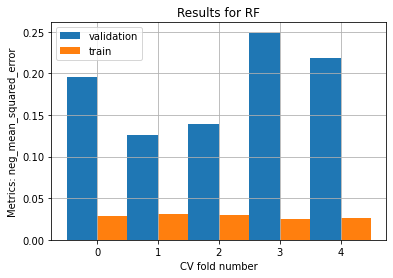

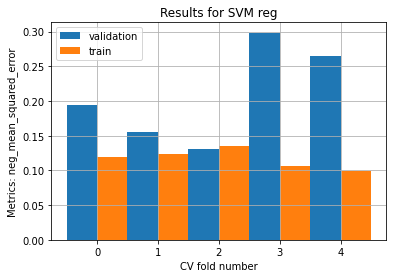

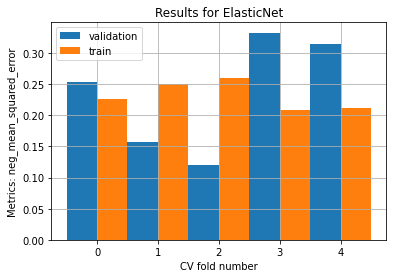

In [20]:
# %%pycodestyle
plot_cv_results(
    sklearn_models_dict_={
        model_name: model.model for model_name, model in all_models.items()
    },
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=5,
    scoring_='neg_mean_squared_error',
    to_put_minus_=True
)

In [32]:
shortlisted_models = {
    model.name: model for model in [RFModel, ElasticNetModel, SVRModel]
}

# Fine tuning

## Grid search

In [33]:
grid_search_results = fit_grid_search(
    shortlisted_models,
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=4,
    scoring_='neg_mean_squared_error'
)

Fitting RF
Fitting ElasticNet
Fitting SVM reg


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If

## Randomized search

In [37]:
rand_search_results = fit_randomized_search(
    shortlisted_models,
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=4,
    n_iter_=10,
    scoring_='neg_mean_squared_error'
)

Fitting RF
Fitting ElasticNet
Fitting SVM reg


In [38]:
print(rand_search_results['RF'].best_estimator_)
print(rand_search_results['SVM reg'].best_estimator_)

RandomForestRegressor(max_depth=6, n_estimators=600, random_state=42)
SVR(C=0.7000000000000001, gamma='auto')


# Check final models for overfit

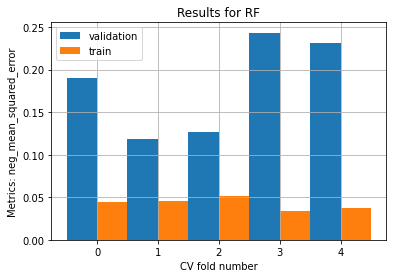

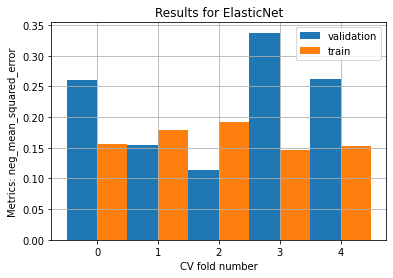

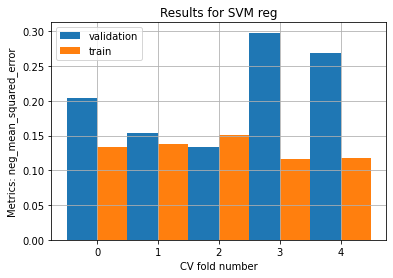

In [39]:
plot_cv_results(
    sklearn_models_dict_ = {
        model_name: result.best_estimator_
        for model_name, result in rand_search_results.items()
    },
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=5,
    scoring_='neg_mean_squared_error',
    to_put_minus_=True
)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave 

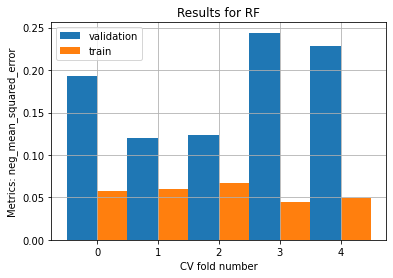

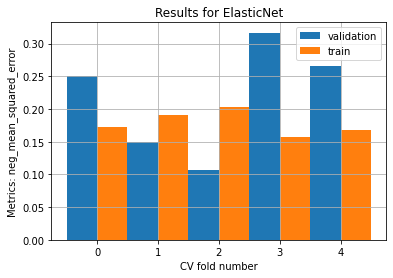

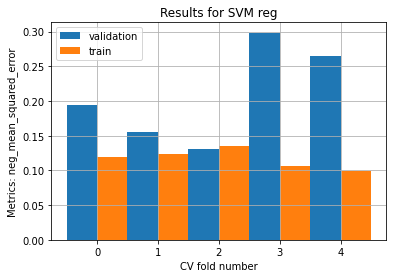

In [43]:
plot_cv_results(
    sklearn_models_dict_ = {
        model_name: result.best_estimator_
        for model_name, result in grid_search_results.items()
    },
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=5,
    scoring_='neg_mean_squared_error',
    to_put_minus_=True
)

# Saving fine tuned candidates (retrained on train+val subset)

In [44]:
manager.save_models(
    {
        f'{model_name}_rand': result.best_estimator_
        for model_name, result in rand_search_results.items()
    }
)

manager.save_models(
    {
        f'{model_name}_grid_search': result.best_estimator_
        for model_name, result in grid_search_results.items()
    }
)